## Import libraries yang digunakan

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import confusion_matrix  
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

### 2 dan 3 Hanya digunakan untuk PC Pribadi dapat dihapus

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13014816338615958289
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10492946486803462422
physical_device_desc: "device: XLA_CPU device"
]


# Dataset "fraud_detection_train.csv"

## a. Fraud Detection

### Mengembangkan sebuah model machine learning untuk melakukan prediksi potensi
### terjadinya fraud pada klaim pelayanan Rumah Sakit berdasarkan dataset train yang
### terdiri dari 200217 observasi dan 53 variables yaitu:
#### • visit_id = id kunjungan
#### • kdkc = kode wilayah kantor cabang
#### • dati2 = kode daerah tingkat II RS
#### • typeppk= kode tipe Rumah Sakit
#### • jkpst = jenis kelamin peserta
#### • umur = umur peserta saat mendapatkan pelayanan
#### • jnspelsep = tingkat pelayanan
#### • los = lama peserta dirawat
#### • cmg = klasifikasi CMG (Case Mix Group)
#### • severitylevel = tingkat urgensi
#### • diagprimer = diagnosa primer
#### • dx2_..._... = diagnosa sekunder
#### • proc.._... = kode kelompok procedure
#### • label = flag fraud; 1:fraud; 0:tidak fraud

In [4]:
"""Import file dan lihat detail, apakah ada missing values atau tidak"""

filepath = "C:/Users/asus/Downloads/Compressed/dataset bpjs/fraud_detection_train.csv"
df = pd.read_csv(filepath)

#Cek Detail Dataset (Apakah terdapat missing values dan sebagainya)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200217 entries, 0 to 200216
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   visit_id       200217 non-null  int64 
 1   kdkc           200217 non-null  int64 
 2   dati2          200217 non-null  int64 
 3   typeppk        200217 non-null  object
 4   jkpst          200217 non-null  object
 5   umur           200217 non-null  int64 
 6   jnspelsep      200217 non-null  int64 
 7   los            200217 non-null  int64 
 8   cmg            200217 non-null  object
 9   severitylevel  200217 non-null  int64 
 10  diagprimer     200217 non-null  object
 11  dx2_a00_b99    200217 non-null  int64 
 12  dx2_c00_d48    200217 non-null  int64 
 13  dx2_d50_d89    200217 non-null  int64 
 14  dx2_e00_e90    200217 non-null  int64 
 15  dx2_f00_f99    200217 non-null  int64 
 16  dx2_g00_g99    200217 non-null  int64 
 17  dx2_h00_h59    200217 non-null  int64 
 18  dx2_

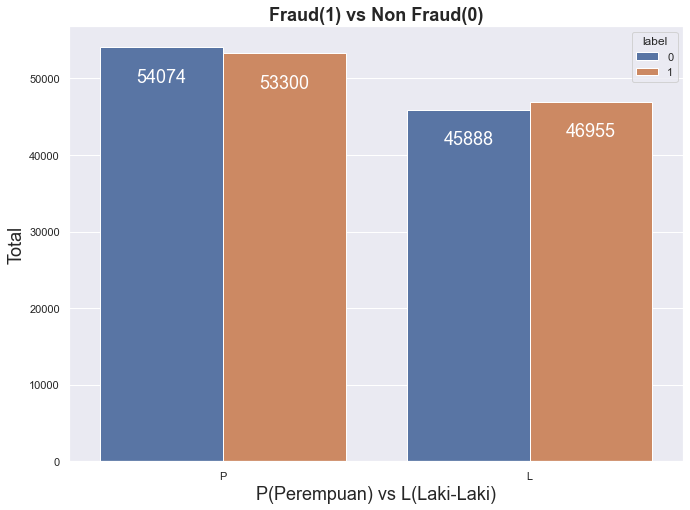

jkpst
L    0.505746
P    0.496396
dtype: float64

In [5]:
"""Cek Distribusi data Fraud vs Non-Fraud berdasarkan jenis kelamin"""

sns.set(rc={'figure.figsize':(11,8)})

ax = sns.countplot("jkpst", hue="label", data=df)
ax.set_title("Fraud(1) vs Non Fraud(0)", fontsize=18, weight="bold")
ax.set_xlabel("P(Perempuan) vs L(Laki-Laki)", fontsize=18)
ax.set_ylabel("Total", fontsize=18)

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=18)

plt.show()

#Rasio perbandingan fraud laki-laki dan Perempuan


df.groupby("jkpst")["label"].sum() / df["jkpst"].value_counts(ascending=True)

### Berdasarkan visualisasi dan rasio di atas dapat disimpulkan bahwa laki-laki memiliki rasio fraud lebih tinggi dibandingkan perempuan. Data tersebut dapat dikatakan balance dan tidak memiliki missing values

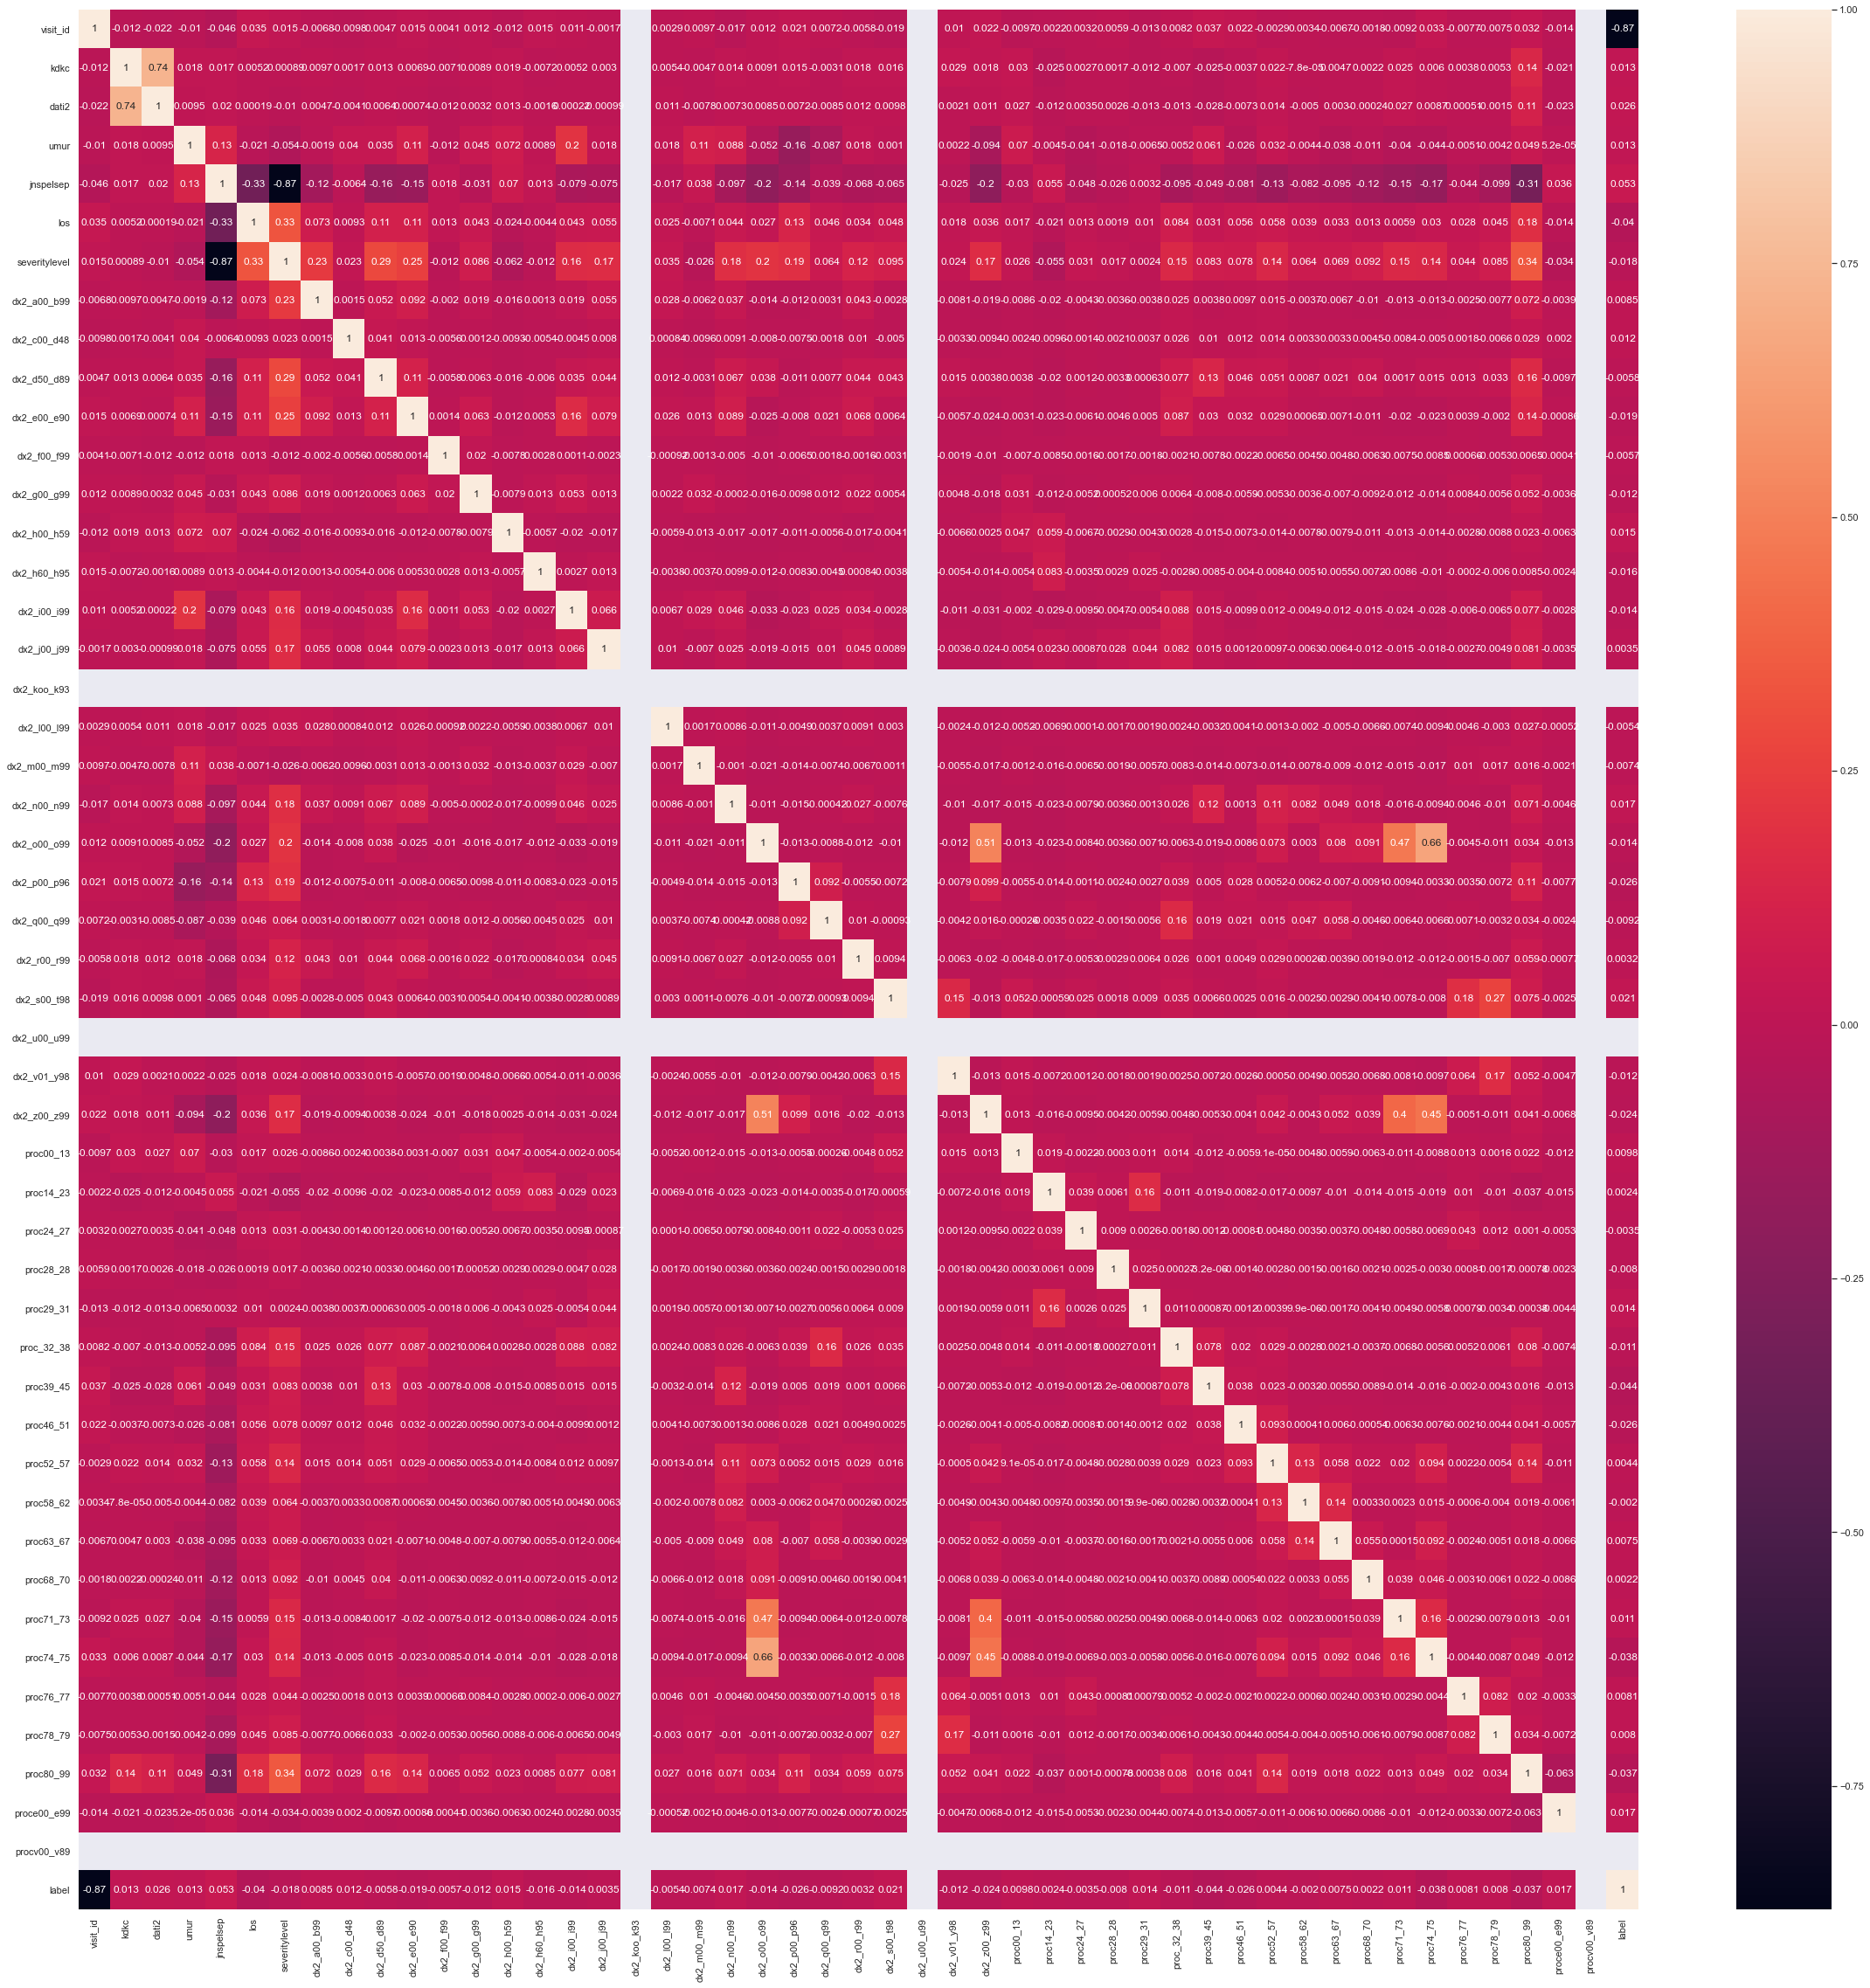

In [6]:
"""Cek relevansi data menggunakan Heatmap korelasi (pearson)"""

plt.figure(figsize= (40,40))
sns.heatmap(df.corr(), annot=True)
plt.show()

berdasarkan heatmap corellation kita dapat meng-drop 3 parameter(kolom), yaitu : \
    1. dx2_koo_k93 \
    2. dx2_u00_u99\
    3. procv00_v89\
Alasannya cukup sederhana dikarenakan values pada ketiga index tersebut semuanya bernilai nol maka dapat disimpulkan data tersebut tidak memiliki pengaruh yang kuat pada hasil label.

## Drop index yang tidak memiliki korelasi dan plot korelasi distribusi data hasil diagnosa primer dengan label(fraud vs non-fraud)

In [7]:
df.drop(["dx2_koo_k93", "dx2_u00_u99", "procv00_v89"], axis=1, inplace=True)

In [8]:
subset = df[["jkpst", "diagprimer", "label"]]
subset.groupby("diagprimer")["jkpst"].count()

diagprimer
a00_b99    10202
c00_d48     9975
d50_d89     9971
e00_e90    10035
f00_f99     9887
g00_g99    10175
h00_h59     9985
h60_h95     9960
i00_i99    10007
j00_j99    10021
k00_k93     9953
l00_l99    10016
m00_m99    10086
n00_n99     9944
o00_o99    10039
p00_p96     9990
q00_q99     9683
r00_r99    10205
s00_t98     9972
u00_u85       22
z00_z99    10089
Name: jkpst, dtype: int64

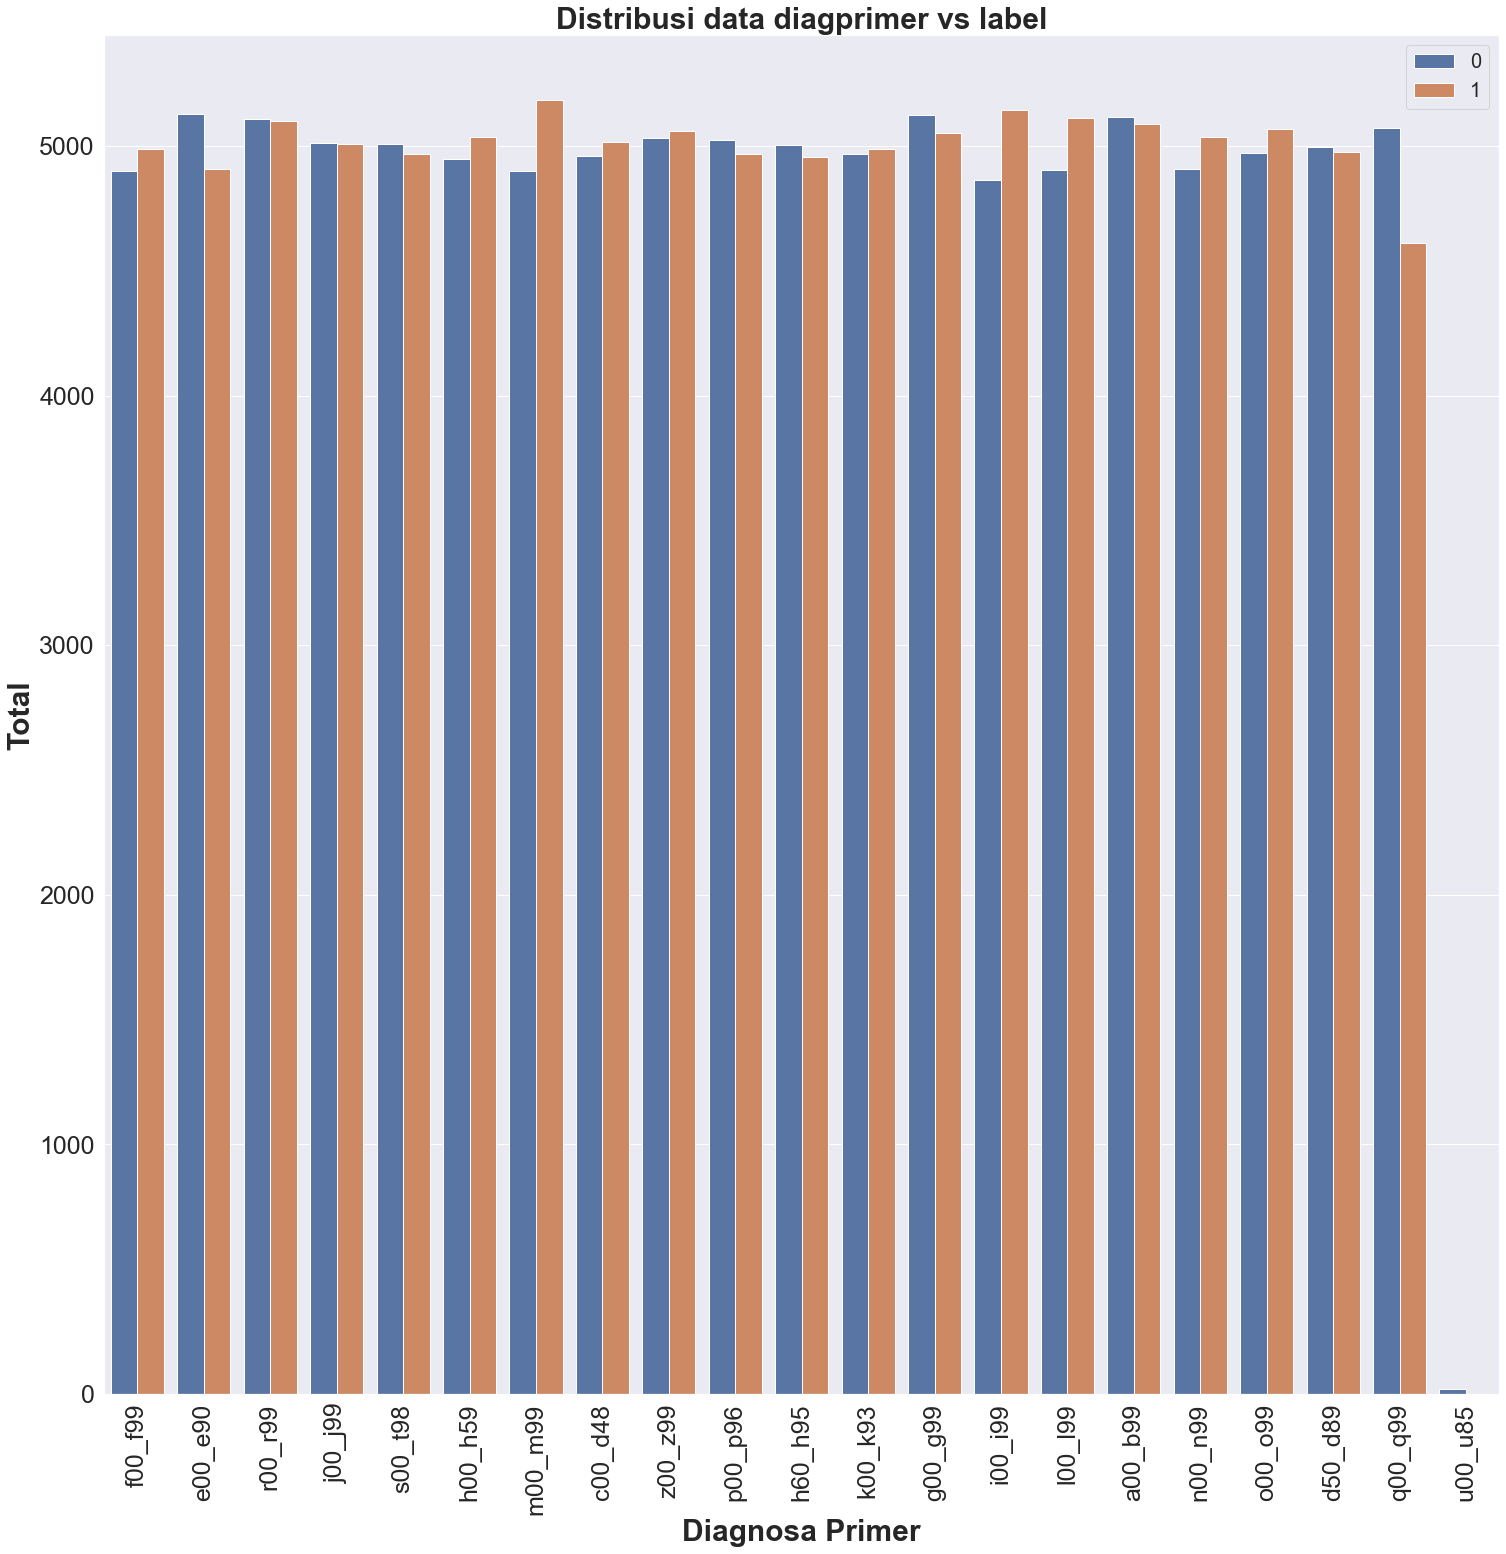

In [9]:
plt.figure(figsize= (25,25))
sns.countplot(x="diagprimer", data=df, hue="label")
plt.xlabel("Diagnosa Primer", fontsize=30, weight='bold')
plt.ylabel("Total", fontsize=30, weight='bold')
plt.title("Distribusi data diagprimer vs label", fontsize=30, weight='bold')
plt.xticks(fontsize=25, rotation=90)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.show()

### Berdasarkan plot distribusi diagprimer, tidak ditemukan imbalance data

## Cek index yang memiliki values object untuk di encode

In [10]:
print("Object type values:",np.count_nonzero(df.select_dtypes('object').columns))
print("___________________________________________________________________________________________")
print(df.select_dtypes('object').columns)
print("___________________________________________________________________________________________")

Object type values: 4
___________________________________________________________________________________________
Index(['typeppk', 'jkpst', 'cmg', 'diagprimer'], dtype='object')
___________________________________________________________________________________________


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['typeppk'] = le.fit_transform(df['typeppk'])
df['jkpst'] = le.fit_transform(df['jkpst'])
df['cmg'] = le.fit_transform(df['cmg'])
df['diagprimer'] = le.fit_transform(df['diagprimer'])

In [12]:
df.describe()

,visit_id,kdkc,dati2,typeppk,jkpst,umur,jnspelsep,los,cmg,severitylevel,...,proc58_62,proc63_67,proc68_70,proc71_73,proc74_75,proc76_77,proc78_79,proc80_99,proce00_e99,label
count,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,...,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000,200217.000000
mean,100109.000000,1147.367816,184.793309,11.213009,0.536288,36.850602,1.669778,1.303356,13.077151,0.444003,...,0.004530,0.005050,0.008381,0.016472,0.018370,0.001518,0.007457,0.847061,0.009225,0.500732
std,57797.813761,574.486224,107.226676,10.097272,0.498683,23.095928,0.470294,5.639751,5.230805,0.725227,...,0.071477,0.073984,0.094393,0.155667,0.144878,0.043995,0.100441,1.301645,0.095603,0.500001
min,1.000000,101.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50055.000000,903.000000,114.000000,2.000000,0.000000,18.000000,1.000000,0.000000,9.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100109.000000,1101.000000,169.000000,8.000000,1.000000,39.000000,2.000000,0.000000,16.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,150163.000000,1314.000000,232.000000,23.000000,1.000000,56.000000,2.000000,2.000000,16.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,200217.000000,2606.000000,528.000000,24.000000,1.000000,109.000000,2.000000,592.000000,22.000000,3.000000,...,3.000000,3.000000,2.000000,4.000000,4.000000,3.000000,7.000000,23.000000,1.000000,1.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200217 entries, 0 to 200216
Data columns (total 50 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   visit_id       200217 non-null  int64
 1   kdkc           200217 non-null  int64
 2   dati2          200217 non-null  int64
 3   typeppk        200217 non-null  int32
 4   jkpst          200217 non-null  int32
 5   umur           200217 non-null  int64
 6   jnspelsep      200217 non-null  int64
 7   los            200217 non-null  int64
 8   cmg            200217 non-null  int32
 9   severitylevel  200217 non-null  int64
 10  diagprimer     200217 non-null  int32
 11  dx2_a00_b99    200217 non-null  int64
 12  dx2_c00_d48    200217 non-null  int64
 13  dx2_d50_d89    200217 non-null  int64
 14  dx2_e00_e90    200217 non-null  int64
 15  dx2_f00_f99    200217 non-null  int64
 16  dx2_g00_g99    200217 non-null  int64
 17  dx2_h00_h59    200217 non-null  int64
 18  dx2_h60_h95    200217 no

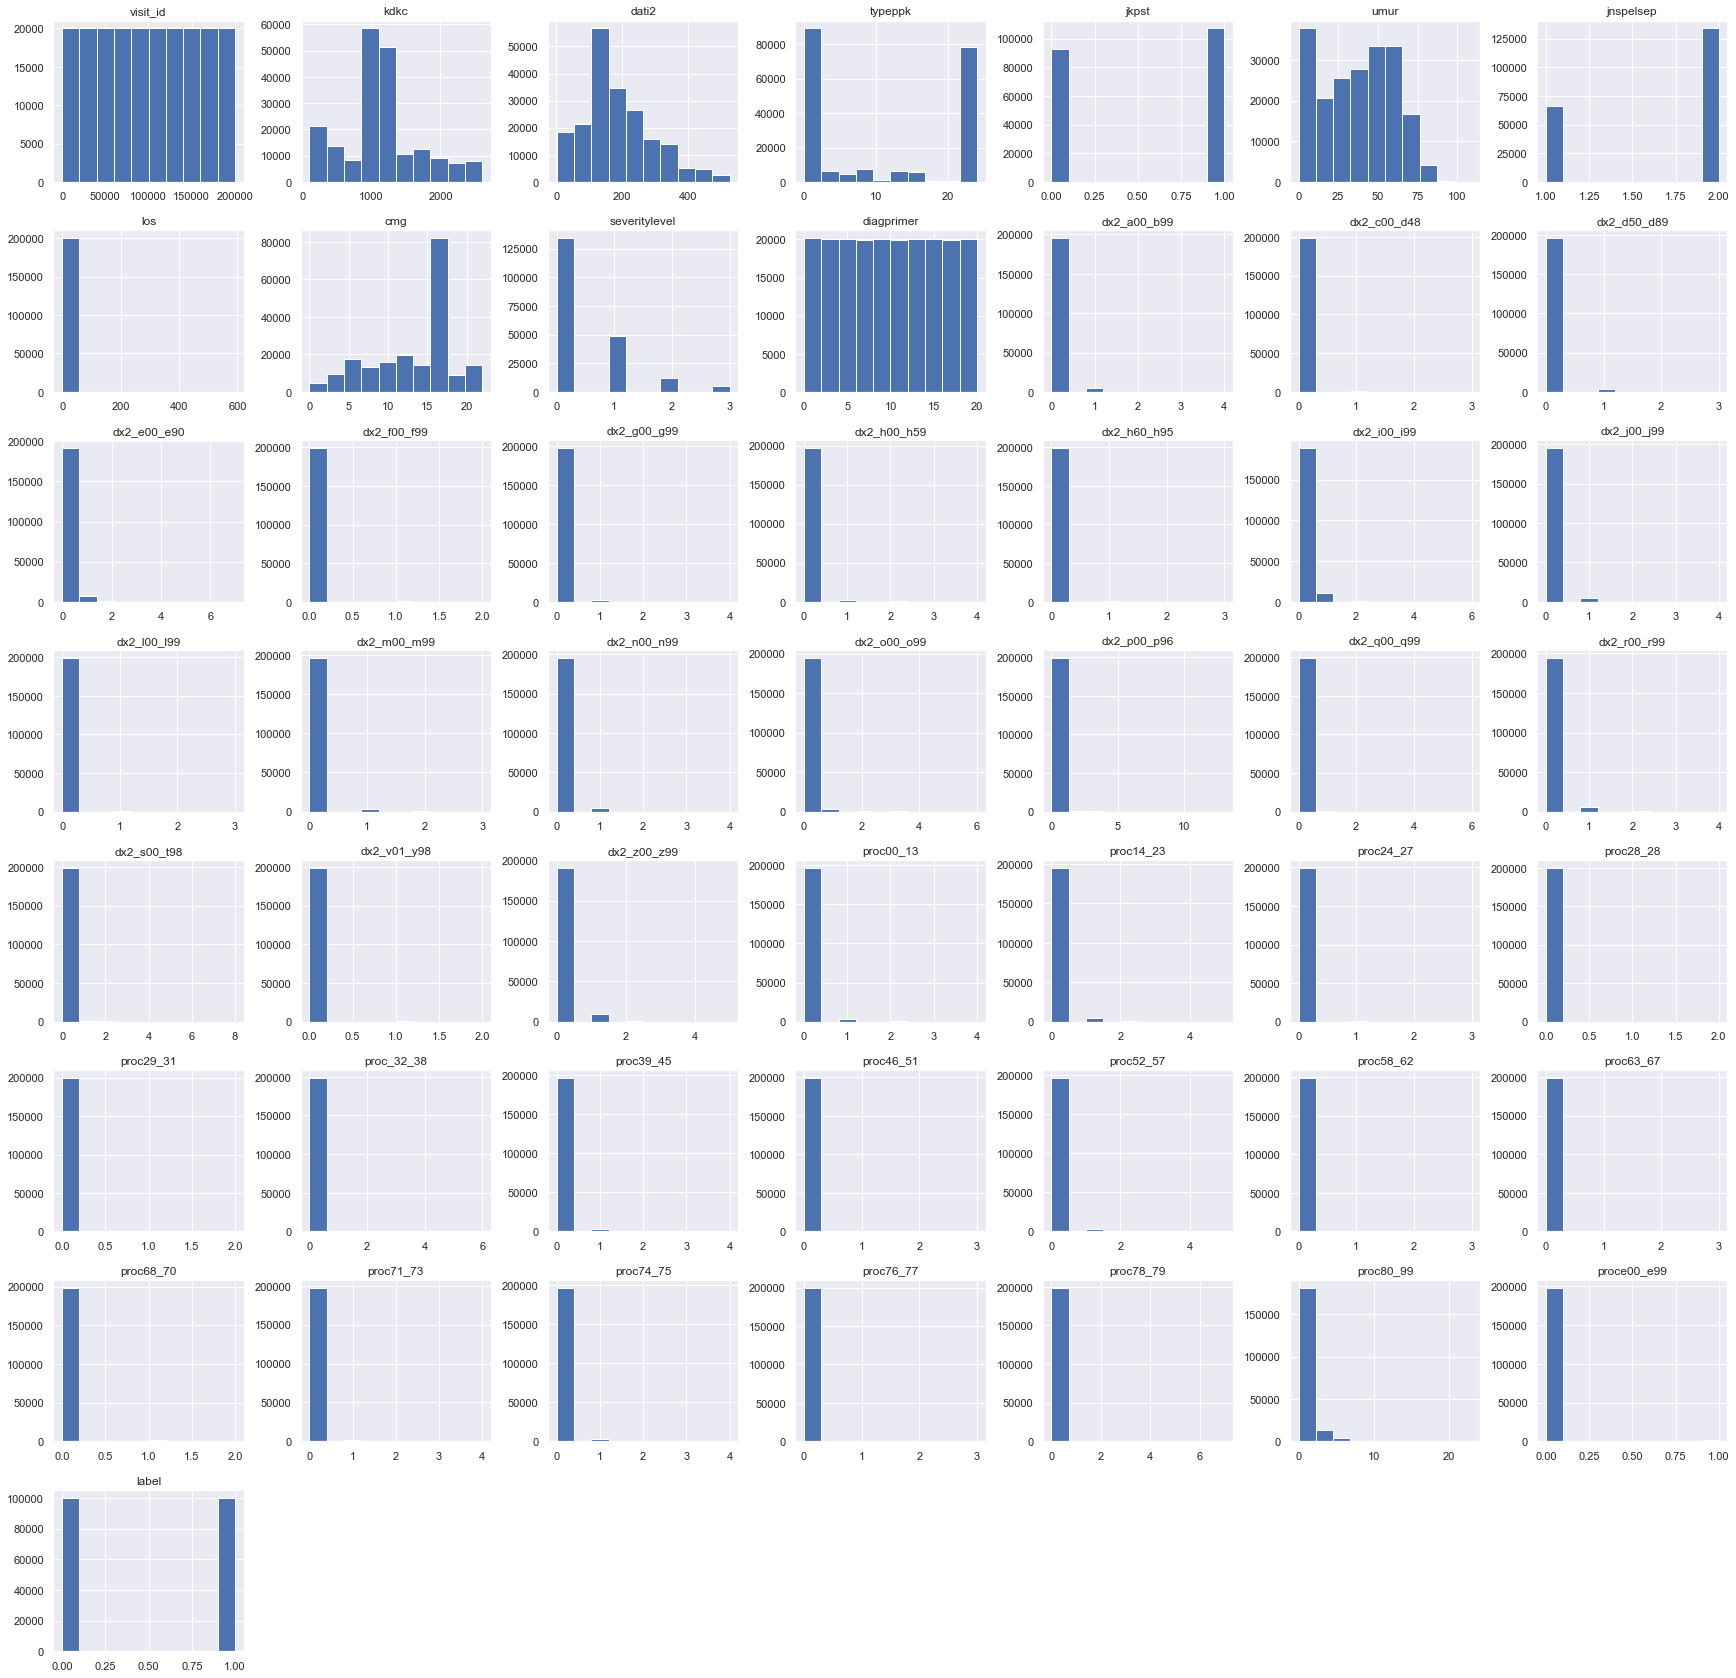

In [14]:
df.hist(figsize=(30,30), ec='w')
plt.show()

### Berdasarkan hasil di atas cukup dilema apakah memang diagnosa sekunder benar-benar perlu diikutsertakan sebagai fitur atau tidak. Keputusan sementara akan dilanjutkan dengan menggunakan diagsekunder sebagai fitur.

In [15]:
def color_(value):
    if value < 0 :
        color = 'red'
    elif value == 1 :
        color = 'blue'
    else:
        color = 'green'
    return 'color: %s' % color
df.corr().style.applymap(color_)

,visit_id,kdkc,dati2,typeppk,jkpst,umur,jnspelsep,los,cmg,severitylevel,diagprimer,dx2_a00_b99,dx2_c00_d48,dx2_d50_d89,dx2_e00_e90,dx2_f00_f99,dx2_g00_g99,dx2_h00_h59,dx2_h60_h95,dx2_i00_i99,dx2_j00_j99,dx2_l00_l99,dx2_m00_m99,dx2_n00_n99,dx2_o00_o99,dx2_p00_p96,dx2_q00_q99,dx2_r00_r99,dx2_s00_t98,dx2_v01_y98,dx2_z00_z99,proc00_13,proc14_23,proc24_27,proc28_28,proc29_31,proc_32_38,proc39_45,proc46_51,proc52_57,proc58_62,proc63_67,proc68_70,proc71_73,proc74_75,proc76_77,proc78_79,proc80_99,proce00_e99,label
visit_id,1.000000,-0.011731,-0.021932,0.048706,0.007115,-0.010438,-0.045508,0.034915,0.006329,0.014872,0.002583,-0.006828,-0.009841,0.004737,0.014710,0.004120,0.011962,-0.012295,0.015021,0.011473,-0.001725,0.002897,0.009741,-0.016929,0.011713,0.021295,0.007206,-0.005773,-0.019370,0.010106,0.021541,-0.009680,-0.002157,0.003187,0.005912,-0.012640,0.008187,0.037471,0.021874,-0.002852,0.003366,-0.006702,-0.001818,-0.009242,0.032540,-0.007684,-0.007534,0.032030,-0.014416,-0.866024
kdkc,-0.011731,1.000000,0.735047,-0.087041,-0.003295,0.018384,0.016699,0.005203,0.006316,0.000892,0.001087,0.009657,0.001694,0.012836,0.006890,-0.007103,0.008913,0.018962,-0.007202,0.005237,0.003006,0.005418,-0.004703,0.013935,0.009091,0.015162,-0.003056,0.018264,0.016444,0.028617,0.018487,0.030126,-0.025214,0.002699,0.001684,-0.011885,-0.006965,-0.024509,-0.003713,0.022214,-0.000078,0.004717,0.002246,0.025413,0.005988,0.003788,0.005327,0.140364,-0.020848,0.013042
dati2,-0.021932,0.735047,1.000000,-0.074694,0.004088,0.009503,0.019685,0.000190,0.024102,-0.010347,-0.003235,0.004740,-0.004139,0.006376,0.000740,-0.011547,0.003217,0.013045,-0.001611,0.000223,-0.000991,0.011303,-0.007803,0.007286,0.008468,0.007199,-0.008458,0.011834,0.009788,0.002077,0.010735,0.027345,-0.011783,0.003499,0.002566,-0.013380,-0.013377,-0.028262,-0.007301,0.014014,-0.005007,0.003028,-0.000235,0.026815,0.008712,0.000509,-0.001456,0.114995,-0.023228,0.026380
typeppk,0.048706,-0.087041,-0.074694,1.000000,0.027933,0.025770,0.004902,-0.027545,0.018934,-0.030976,0.012698,-0.019835,-0.031774,-0.041804,-0.039231,-0.014855,-0.021243,0.021461,-0.003968,-0.025257,-0.023486,-0.017059,0.010260,-0.013263,0.002083,-0.038505,-0.027528,-0.024892,-0.034140,-0.023197,-0.016862,0.016317,-0.017735,-0.016789,-0.000018,-0.019088,-0.032430,-0.014284,-0.012680,-0.023623,0.004864,-0.003553,0.003771,-0.007971,0.009459,-0.012837,-0.016533,-0.086396,-0.045642,-0.057364
jkpst,0.007115,-0.003295,0.004088,0.027933,1.000000,0.042125,-0.013348,-0.023958,0.067083,0.010131,0.002104,-0.018422,0.026748,0.011669,0.009217,-0.015676,-0.004027,0.016135,0.001319,-0.003122,-0.020905,-0.006900,0.029742,-0.009917,0.141270,-0.018781,-0.015347,-0.002953,-0.028849,-0.021564,0.092615,0.000090,0.007024,-0.002498,-0.005485,-0.004804,-0.009872,-0.015932,-0.011006,-0.021280,-0.046159,-0.004087,0.080864,0.096338,0.113827,-0.009341,-0.027091,0.000621,-0.005188,-0.009326
umur,-0.010438,0.018384,0.009503,0.025770,0.042125,1.000000,0.128256,-0.020829,-0.052761,-0.053836,-0.128203,-0.001917,0.040204,0.035004,0.105917,-0.011816,0.044672,0.072040,0.008868,0.199329,0.017609,0.018222,0.106364,0.087791,-0.051937,-0.163068,-0.087092,0.017903,0.001027,0.002168,-0.094135,0.069715,-0.004546,-0.040769,-0.017680,-0.006478,-0.005206,0.060572,-0.025828,0.032361,-0.004434,-0.038020,-0.011117,-0.040131,-0.043729,-0.005051,-0.004239,0.049301,0.000052,0.013498
jnspelsep,-0.045508,0.016699,0.019685,0.004902,-0.013348,0.128256,1.000000,-0.329130,0.360984,-0.871875,0.027315,-0.117270,-0.006429,-0.164915,-0.149916,0.017652,-0.030758,0.070432,0.013118,-0.078836,-0.074532,-0.017282,0.037621,-0.097139,-0.198647,-0.140175,-0.038933,-0.067561,-0.064773,-0.025291,-0.202230,-0.029927,0.054517,-0.048208,-0.025828,0.003171,-0.094717,-0.049204,-0.080557,-0.133978,-0.081644,-0.094619,-0.123186,-0.149951,-0.174351,-0.044323,-0.098966,-0.307863,0.036427,0.053215
los,0.034915,0.005203,0.000190,-0.027545,-0.023958,-0.020829,-0.329130,1.000000,-0.168135,0.331709,-0.042744,0.

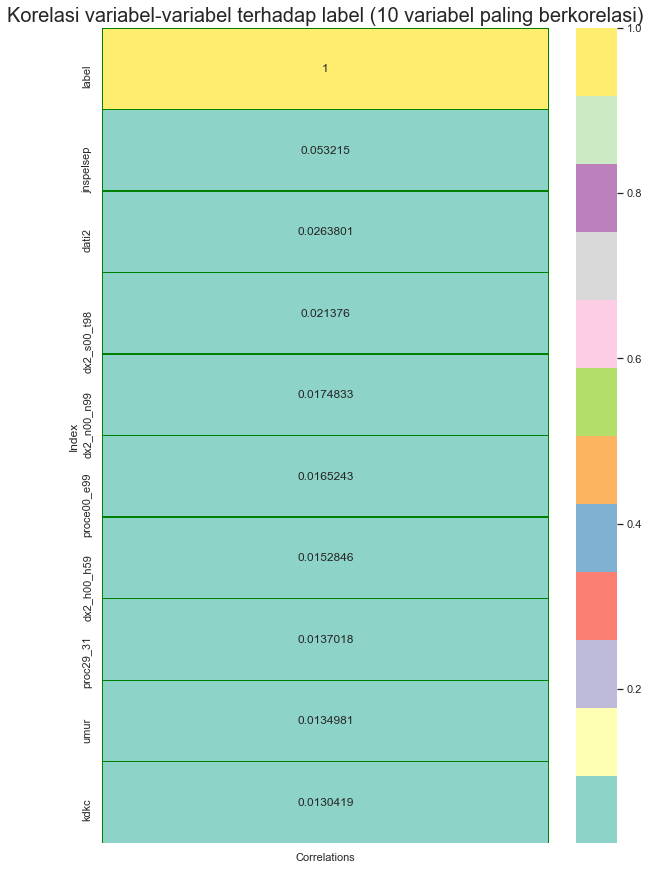

In [16]:
corr = df.corrwith(df['label'],method='pearson').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(10)

plt.figure(figsize=(10, 15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Korelasi variabel-variabel terhadap label (10 variabel paling berkorelasi)", fontsize=20)
plt.show()

## Splitting data, Subset, dan Pemodelan menggunakan GaussianNB(Gaussian Naive Bayes)

In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(["label"], axis=1)
target = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3,
                                                   random_state=0)

In [18]:
MLA = [GaussianNB()]    
MLA_columns=[]
MLA_compare= pd.DataFrame(columns=MLA_columns)
row_index=0
datacsv = []

for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    MLA_name = alg.__class__.__name__

    MLA_compare.loc[row_index,'Model Name'] = MLA_name

    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 2)

    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 2)

    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted),2)

    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),2)

    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(y_test, predicted),2)

    row_index+=1

MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)   

print("Hasil Model \n\n", MLA_compare)

predicted = pd.DataFrame(predicted)

Hasil Model 

    Model Name  Train Accuracy  Test Accuracy  Precision  Recall  F1 score
0  GaussianNB            0.99           0.99       0.99    0.98      0.99


In [32]:
MLA = GaussianNB()  
MLA_columns=[]
MLA_compare= pd.DataFrame(columns=MLA_columns)
row_index=0
datacsv = []

predicted = MLA.fit(X_train, y_train).predict(X_test)
MLA_name = alg.__class__.__name__

MLA_compare.loc[row_index,'Model Name'] = MLA_name

MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 2)

MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 2)

MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted),2)

MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),2)

MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(y_test, predicted),2)

MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)   

print("Hasil Model \n\n", MLA_compare)

predicted = pd.DataFrame(predicted)

Hasil Model 

    Model Name  Train Accuracy  Test Accuracy  Precision  Recall  F1 score
0  GaussianNB            0.99           0.99       0.99    0.98      0.99


In [19]:
#Cek fitur yang memiliki skor paling tinggi

from sklearn.feature_selection import SelectKBest,mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)
fit = bestfeatures.fit(X,target,)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns) 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 
print(featureScores.nlargest(10,'Score'))  

          Feature     Score
0        visit_id  0.693137
2           dati2  0.043452
1            kdkc  0.030780
6       jnspelsep  0.016239
8             cmg  0.011513
3         typeppk  0.010559
7             los  0.007324
4           jkpst  0.005904
9   severitylevel  0.004224
47      proc80_99  0.003683


In [20]:
testing_data = pd.read_csv("C:/Users/asus/Downloads/Compressed/dataset bpjs/format_fraud_detection.csv")
testing_data = testing_data.merge(X_test[["visit_id"]], how="outer")
testing_data

,predict_label,visit_id
0,NaN,195972
1,NaN,183272
2,NaN,187636
3,NaN,121603
4,NaN,34685
...,...,...
60061,NaN,109655
60062,NaN,171284
60063,NaN,112715
60064,NaN,119752


In [21]:
testing_data = testing_data.merge(X_train[["visit_id"]], how="outer")
testing_data

,predict_label,visit_id
0,NaN,195972
1,NaN,183272
2,NaN,187636
3,NaN,121603
4,NaN,34685
...,...,...
200212,NaN,176964
200213,NaN,117953
200214,NaN,173686
200215,NaN,43568


### Merge nilai predict label

In [22]:
testing_data["predict_label"] = predicted
testing_data

,predict_label,visit_id
0,0.0,195972
1,0.0,183272
2,0.0,187636
3,0.0,121603
4,1.0,34685
...,...,...
200212,NaN,176964
200213,NaN,117953
200214,NaN,173686
200215,NaN,43568


In [23]:
testing_data = testing_data[["visit_id", "predict_label"]] #Ubah susunan
testing_data

,visit_id,predict_label
0,195972,0.0
1,183272,0.0
2,187636,0.0
3,121603,0.0
4,34685,1.0
...,...,...
200212,176964,NaN
200213,117953,NaN
200214,173686,NaN
200215,43568,NaN


In [24]:
training_data = X_train[["visit_id"]]
training_data["predict_label"] = pd.DataFrame(y_train)
training_data

,visit_id,predict_label
4425,4426,1
179115,179116,0
170946,170947,0
62387,62388,1
184791,184792,0
...,...,...
176963,176964,0
117952,117953,0
173685,173686,0
43567,43568,1


In [ ]:
all.sort_values("visit_id", inplace=True)

In [ ]:
all.to_csv("TESSSS.csv", index=False)

# Predict Unseen Data

In [26]:
unseen_df = pd.read_csv("C:/Users/asus/Downloads/BPJS HACKATHON/TAHAP 2/Fraud Detection/fraud_detection_val.csv")

In [27]:
unseen_df.head()

,visit_id,kdkc,dati2,typeppk,jkpst,umur,jnspelsep,los,cmg,severitylevel,...,proc58_62,proc63_67,proc68_70,proc71_73,proc74_75,proc76_77,proc78_79,proc80_99,proce00_e99,procv00_v89
0,1,102,1,SD,P,40,2,0,Q,0,...,0,0,0,0,0,0,0,0,0,0
1,2,102,1,SD,L,12,2,0,Q,0,...,0,0,0,0,0,0,0,0,0,0
2,3,102,1,SD,L,50,2,0,K,0,...,0,0,0,0,0,0,0,0,0,0
3,4,102,1,SD,P,41,2,0,K,0,...,0,0,0,0,0,0,0,0,0,0
4,5,102,1,SD,P,67,1,3,I,1,...,0,0,0,0,0,0,0,1,0,0


In [28]:
unseen_df.drop(["dx2_koo_k93", "dx2_u00_u99", "procv00_v89"], axis=1, inplace=True)

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
unseen_df['typeppk'] = le.fit_transform(unseen_df['typeppk'])
unseen_df['jkpst'] = le.fit_transform(unseen_df['jkpst'])
unseen_df['cmg'] = le.fit_transform(unseen_df['cmg'])
unseen_df['diagprimer'] = le.fit_transform(unseen_df['diagprimer'])

In [40]:
predicted = MLA.fit(X_train, y_train).predict(unseen_df)

In [41]:
hasil = pd.DataFrame(predicted)

In [42]:
hasil.to_csv("C:/Users/asus/Downloads/BPJS HACKATHON/TAHAP 2/Fraud Detection/hasil.csv", index=None)